In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from rslds import RSLDS

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
C_syn = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_e.npy")[1:]

In [3]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
hid_no = 3 # H
sub_no = 5 # N
state_no = 3 # K
enc_no = 15
in_no = 2000
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_length = 50000
batch_size = 9
iter_no = 9990
epoch_no = iter_no*batch_length*batch_size//T_train

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
C_syn = torch.from_numpy(C_syn).to(device).float()
model = RSLDS(25000, sub_no, state_no, hid_no, enc_no, batch_size, C_syn, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

5016


In [6]:
temp_list = np.logspace(1,0,20)
temp_count = 0
beta = 1

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    if (i%20 == 19) & (temp_count < 19):
        temp_count += 1
    temp = temp_list[temp_count]
    if i%20 == 19:
        beta *= 0.75
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    Y_prob, init_prob, seq_prob, gamma_prior_prob = model(batch_V[:,10000:35000], batch_E_neural[:,10000:35000,:], temp, beta)
    
    loss = -Y_prob - init_prob - seq_prob - gamma_prior_prob*beta
        
    loss.backward()    
    optimizer.step()
    
    print(i, np.round(-Y_prob.item(), 6),
          np.round(-init_prob.item()-seq_prob.item(), 6),
          np.round(-gamma_prior_prob.item(), 6),
         np.round(time.time() - s, 5))
    
    if (i%20 == 19) and (i >= 400):
        model.eval()
        test_V_pred, test_X_out, test_Z_out = model.test(test_E_neural[10000:35000,:])
                 
        test_score = explained_variance_score(V_test[10000:35000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[10000:35000]-test_V_pred)**2).item()
        
        print("TEST", i, np.round(test_score,6),
              np.round(test_mse,6))
    

<ipython-input-6-a546b8d95ed4>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 16733.636719 2971785.812691 3787098.75 15.73931
1 14811.024414 2831188.728363 3859011.25 16.29108
2 15657.140625 2714707.195015 3922267.0 15.68869
3 14578.707031 2615207.924782 3982779.5 16.3704
4 14626.0 2535256.644859 4038641.75 15.70036
5 12805.970703 2468835.671562 4085459.5 15.68566
6 13391.246094 2413162.581955 4117914.5 15.93669
7 13008.027344 2364056.090851 4132006.75 15.71806
8 13494.009766 2317125.1978 4122793.0 15.66538
9 12620.09375 2269634.208984 4087559.25 15.9626
10 12960.694336 2230619.264069 4027503.0 16.21661
11 12803.636719 2201724.239273 3950937.5 15.77197
12 13238.101562 2182872.662064 3862164.5 16.84352
13 11742.588867 2192446.20015 3769000.25 16.87579
14 12596.935547 2215570.034859 3675732.5 16.65023
15 12445.922852 2251564.213531 3593448.25 16.88884
16 12754.037109 2295812.46376 3520065.5 15.80106
17 13176.089844 2334452.782135 3465716.75 15.78752
18 12892.796875 2341385.711639 3429268.25 16.7745
19 12624.884766 2304580.939613 3421721.0 15.80631
20 13470.50585

166 448.924438 913776.880463 3396561.0 15.81535
167 441.385681 912695.595795 3404540.25 15.80105
168 387.430573 910737.19445 3411974.25 16.69538
169 411.176483 909233.041 3419997.0 16.01497
170 369.424774 907687.660797 3427330.5 16.77543
171 353.670929 906192.751724 3435440.0 15.62438
172 332.535156 904604.38475 3442704.5 15.64561
173 302.51416 903335.04615 3450664.5 15.65729
174 335.169708 902077.970703 3457435.75 15.63985
175 320.856506 901105.984764 3463940.0 15.88616
176 289.027405 899747.636681 3469954.25 16.00826
177 224.053528 898626.165115 3475910.0 15.81396
178 276.264404 898200.741951 3481618.5 15.8102
179 281.111359 856771.361214 3585112.75 15.88078
180 293.33667 856005.03334 3590515.5 15.79523
181 317.869141 855109.394196 3596100.25 15.73351
182 273.539734 854338.080612 3601989.0 15.77109
183 213.034409 853046.382599 3606690.5 15.71022
184 261.977112 851950.231613 3612380.75 16.06745
185 235.295105 850908.393211 3617670.5 15.86716
186 306.300354 849807.536743 3622847.0 15.7

338 114.347122 571438.841202 5318917.5 15.66054
339 122.808502 543451.386475 5673919.0 15.66613
340 130.021957 543386.846161 5673527.0 15.66354
341 99.670792 543430.928841 5672539.0 15.65381
342 126.748688 543541.45755 5672705.5 16.73037
343 93.681961 543548.272369 5672390.5 15.74609
344 83.905701 543522.276512 5669275.0 15.8226
345 103.019585 543622.908928 5669836.0 15.7997
346 121.097321 543722.080093 5672759.0 15.7771
347 157.94281 543873.703201 5672403.5 15.80296
348 123.972244 543828.661873 5671261.5 15.81415
349 118.679123 543909.955414 5671554.0 15.85786
350 111.066879 543881.852676 5673732.0 15.78654
351 113.091202 543863.476059 5670365.5 15.8097
352 96.846985 543961.62101 5671209.0 16.23243
353 128.804474 544024.218277 5673258.0 16.88217
354 86.519905 544099.663269 5671805.5 15.63159
355 102.389389 544264.715805 5669518.0 15.66361
356 118.096855 544155.91304 5670336.0 15.6338
357 102.969971 544203.548485 5668688.0 15.6756
358 103.848404 544245.022156 5668626.0 15.64379
359 137

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

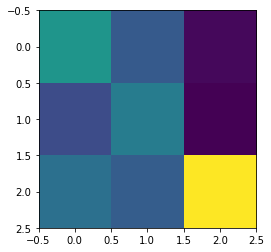

In [11]:
plt.imshow(model.W_xx[0,0].cpu().detach().numpy())
plt.colorbar()

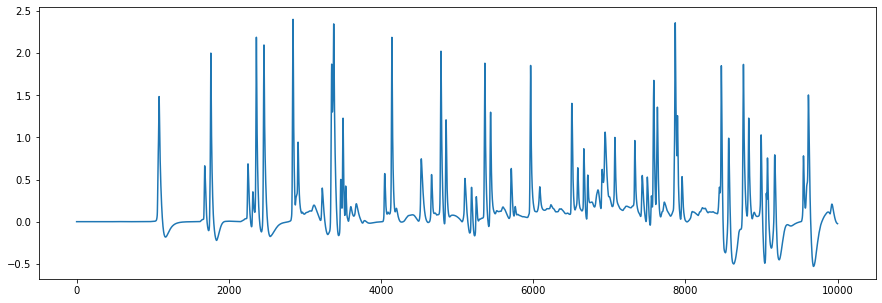

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.flatten().cpu().detach().numpy()[16000:26000])

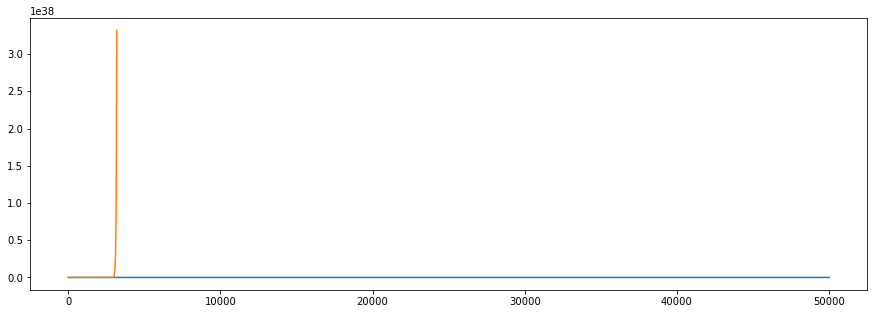

In [14]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.flatten().cpu().detach().numpy())

In [15]:
Z_out = np.zeros((50000,4))

for t in range(50000):
    for n in range(4):
        Z_out[t,n] = torch.argmax(test_Z[0,t,n])

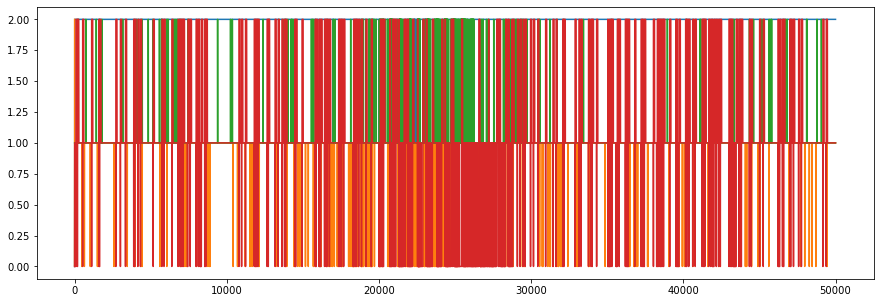

In [14]:
plt.figure(figsize = (15,5))

for n in range(4):
    plt.plot(Z_out[:,n])

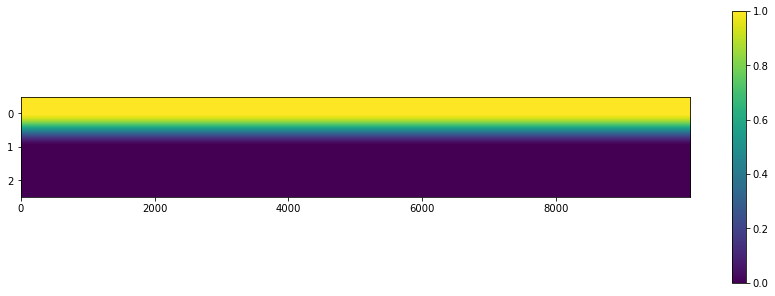

In [25]:
plt.figure(figsize = (15,5))
plt.imshow(test_Z[0,16000:26000,0].cpu().detach().numpy().T, aspect=500)
plt.colorbar()